# Number of Features

Based on other experiments, binary classification problems with just two features are enough to result in feedback loops. Let's now see what the relationship is between FPR increase and number of features.

In [15]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_feedback, make_gaussian_data

%matplotlib inline

In [31]:
def results_to_dataframe(initial_fprs, updated_fprs, features):
    data = {"type": [], "fpr": [], "num_features": []}

    for num_features in features:
        data["type"] += ["initial"] * len(initial_fprs[num_features])
        data["num_features"] += [num_features] * len(initial_fprs[num_features])
        data["fpr"] += initial_fprs[num_features]

        data["type"] += ["updated"] * len(updated_fprs[num_features])
        data["num_features"] += [num_features] * len(updated_fprs[num_features])
        data["fpr"] += updated_fprs[num_features]

    return pd.DataFrame(data)

## sklearn Data

In [16]:
n_train = 10000
n_update = 10000
n_test = 10000

In [17]:
seeds = np.arange(100)
features = np.arange(10) + 2
initial_fprs_sklearn = {num_features: [] for num_features in features}
updated_fprs_sklearn = {num_features: [] for num_features in features}

for seed in seeds:
    for num_features in features:
        np.random.seed(seed)

        x, y = make_classification(n_train + n_update + n_test, n_features=num_features, n_informative=num_features, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100)

        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        initial_fprs_sklearn[num_features].append(initial_fpr)
        updated_fprs_sklearn[num_features].append(updated_fpr)

In [24]:
data_sklearn = results_to_dataframe(initial_fprs_sklearn, updated_fprs_sklearn, features)

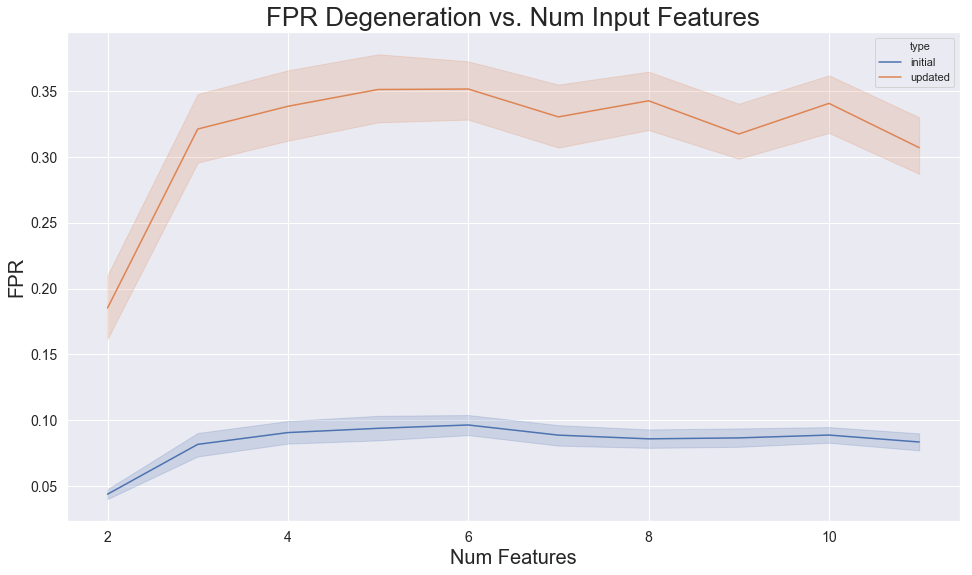

In [25]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.lineplot(x="num_features", y="fpr", hue="type", data=data_sklearn, ax=ax)
ax.set_xlabel("Num Features", size=20)
ax.set_ylabel("FPR", size=20)
ax.set_title("FPR Degeneration vs. Num Input Features", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
fig.show()

## Gaussian Data

In [26]:
n_train = 10000
n_update = 10000
n_test = 10000

In [27]:
m0 = -1
m1 = 1

s0 = 1
s1 = 1

p0 = 0.5
p1 = 1 - p0

In [29]:
seeds = np.arange(100)
features = np.arange(10) + 1
initial_fprs_gaussian = {num_features: [] for num_features in features}
updated_fprs_gaussian = {num_features: [] for num_features in features}

for seed in seeds:
    for num_features in features:
        np.random.seed(seed)

        x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=num_features)

        x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=num_features)
        x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=num_features)
        
        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model, _ = update_model_feedback(model, x_update, y_update, None, None, 100)

        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        initial_fprs_gaussian[num_features].append(initial_fpr)
        updated_fprs_gaussian[num_features].append(updated_fpr)

In [32]:
data_gaussian = results_to_dataframe(initial_fprs_gaussian, updated_fprs_gaussian, features)

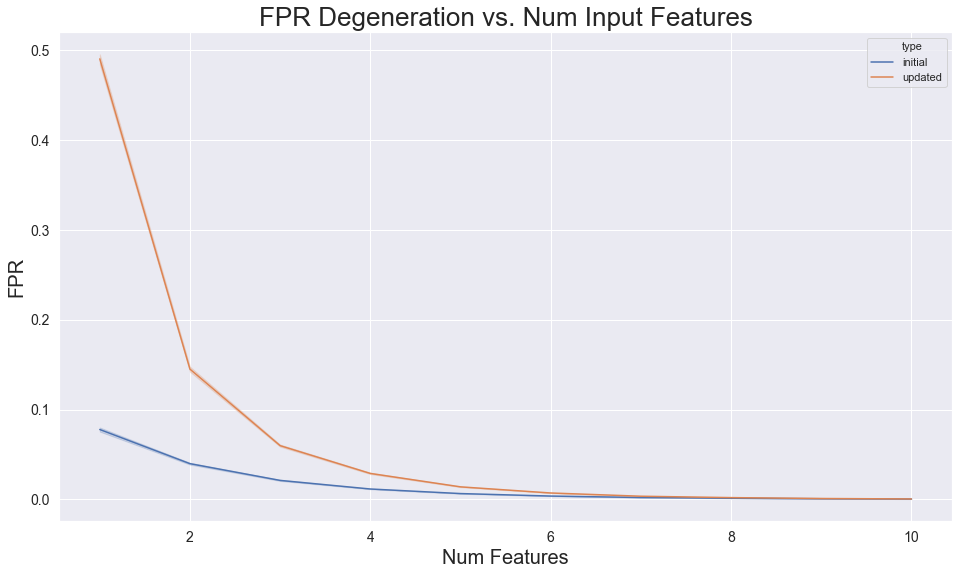

In [33]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.lineplot(x="num_features", y="fpr", hue="type", data=data_gaussian, ax=ax)
ax.set_xlabel("Num Features", size=20)
ax.set_ylabel("FPR", size=20)
ax.set_title("FPR Degeneration vs. Num Input Features", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
fig.show()

In [34]:
data_gaussian

,type,fpr,num_features
0,initial,0.0646,1
1,initial,0.0918,1
2,initial,0.0638,1
3,initial,0.1046,1
4,initial,0.0865,1
5,initial,0.0918,1
6,initial,0.0828,1
7,initial,0.0668,1
8,initial,0.0671,1
9,initial,0.0767,1
